In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
     

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
# data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data['boolQuality'][data['quality']>4.5] = 1

# note: use the following lines to avoid the warning message
#tmp = (data['quality']>qualThreshold ).astype(int)
#data['boolQuality'] = tmp
  

In [6]:
def createAdataset(qualThreshold):
    data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
#     data['boolQuality'][data['quality']>4.5] = 1

# note: use the following lines to avoid the warning message
    tmp = (data['quality']>qualThreshold ).astype(int)
    data['boolQuality'] = tmp
    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None] # transform to matrix
     #  use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

        # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

        # finally, translate into dataloader objects
    batchsize    = 64
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     


    return train_loader,test_loader
    

In [4]:
# # convert from pandas dataframe to tensor
# dataT  = torch.tensor( data[cols2zscore].values ).float()
# labels = torch.tensor( data['boolQuality'].values ).float()
# labels = labels[:,None] # transform to matrix
     


In [5]:
# #  use scikitlearn to split the data
# train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# # then convert them into PyTorch Datasets (note: already converted to tensors)
# train_data = torch.utils.data.TensorDataset(train_data,train_labels)
# test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# # finally, translate into dataloader objects
# batchsize    = 64
# train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
     


In [7]:
train_loader,test_loader=createAdataset(5)


In [8]:
qualityRatings=train_loader.dataset.tensors[1].detach()
print(f"{torch.sum(qualityRatings==0).item()} low_rated wines")
print(f"{torch.sum(qualityRatings==1).item()} high_rated wines")


670 low_rated wines
767 high_rated wines


In [9]:

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11,16)

        ### hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        ### output layer
        self.output = nn.Linear(32,1)

        # activation funcion to pass through
#         self.actfun = actfun

  # forward pass
    def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.
#         actfun = getattr(torch.nn,self.actfun)
        
        x = F.leaky_relu( self.input(x) )
        x = F.leaky_relu( self.fc1(x) )
        x = F.leaky_relu( self.fc2(x) )
        return self.output(x)

In [10]:
numepochs = 500

def trainTheModel():

  # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

      # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        winenet.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

          # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # loss from this batch
            batchLoss.append(loss.item())

          # compute training accuracy for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
            trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
            losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = winenet(X)
        testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

      # function output
    return trainAcc,testAcc,losses 



In [11]:
train_loader,test_loader=createAdataset(5)

winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()


In [12]:
X,y=next(iter(test_loader))
yHat=winenet(X)
itemAccuracy=((yHat>0)==y).float()
perQualAcc=[100*torch.mean(itemAccuracy[y==0]) , 100*torch.mean(itemAccuracy[y==1])]
perQualAcc

[tensor(91.5254), tensor(74.2574)]

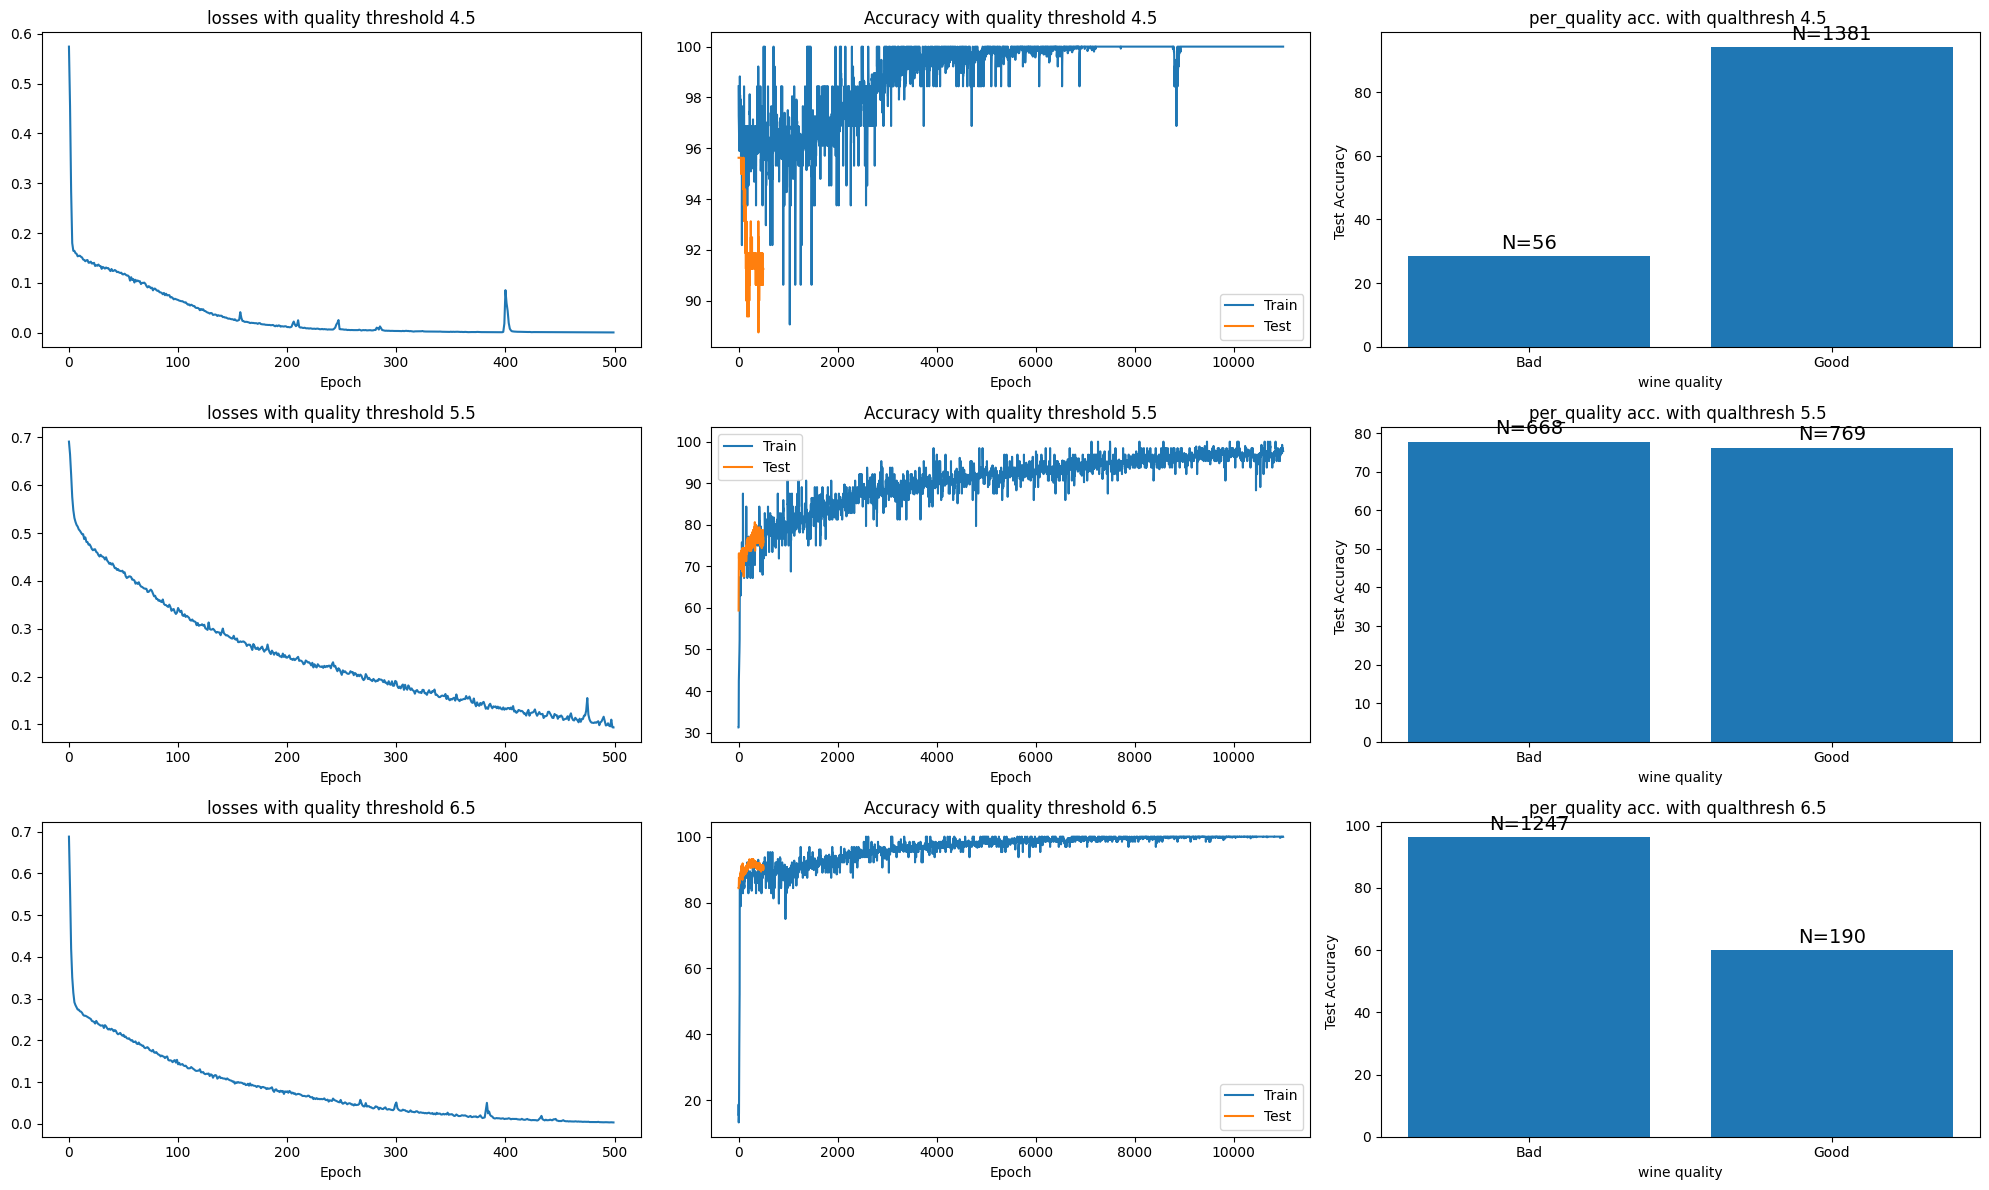

In [20]:
fig,ax = plt.subplots(3,3,figsize=(20,12))
qualityThresholds=[4,5,6]
for qual in range(len(qualityThreshold)):
    train_loader,test_loader=createAdataset(qualityThresholds[qual] )


    winenet = ANNwine()
    trainAcc,testAcc,losses = trainTheModel()
    X,y=next(iter(test_loader))
    yHat=winenet(X)
    itemAccuracy=((yHat>0)==y).float()
    perQualAcc=[100*torch.mean(itemAccuracy[y==0]) , 100*torch.mean(itemAccuracy[y==1])]


    
    

    ax[qual,0].plot(losses)
    ax[qual,0].set_title(f'losses with quality threshold {qualityThresholds[qual]}.5')
    ax[qual,0].set_xlabel('Epoch')
    ax[qual,0].grid()
    
    
    ax[qual,1].plot(trainAcc,label='Train')
    ax[qual,1].plot(testAcc,label='Test')
    
    ax[qual,1].set_title(f'Accuracy with quality threshold {qualityThresholds[qual]}.5')
    ax[qual,1].set_xlabel('Epoch')
    ax[qual,1].legend()
    ax[qual,0].grid()
    
    bh=ax[qual,2].bar(['Bad','Good'],perQualAcc)
    ax[qual,2].set_xlabel('wine quality')
    ax[qual,2].set_ylabel('Test Accuracy ')
    ax[qual,2].set_title(f'per_quality acc. with qualthresh {qualityThresholds[qual]}.5 ')
    
    for i,r in enumerate(bh):
        N=torch.sum(train_loader.dataset.tensors[1]==i).item()
        ax[qual,2].text(r.get_x()+r.get_width()/2,r.get_height()+1,f'N={N}',ha='center',va='bottom',fontsize=14)
plt.tight_layout()
plt.show()
    
    
    
    
    
# # common features
# for i in range(2):
#     ax[i].legend(activation_funs)
#     ax[i].set_xlabel('Epoch')
#     ax[i].set_ylabel('Accuracy (%)')
#     ax[i].set_ylim([40,100])
#     ax[i].grid()

plt.show()

In [36]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# data = pd.read_csv(url,sep=';')
# data = data[data['total sulfur dioxide']<200] # drop a few outliers

# # z-score all columns except for quality
# cols2zscore = data.keys()
# cols2zscore = cols2zscore.drop('quality')
# data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# # create a new column for binarized (boolean) quality
# data['boolQuality'] = 0
# # data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data['boolQuality'][data['quality']>5.5] = 1

# # note: use the following lines to avoid the warning message
# #tmp = (data['quality']>qualThreshold ).astype(int)
# #data['boolQuality'] = tmp
trainAcc

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,


In [16]:
torch.sum(train_loader.dataset.tensors[1]==1).item()

1437

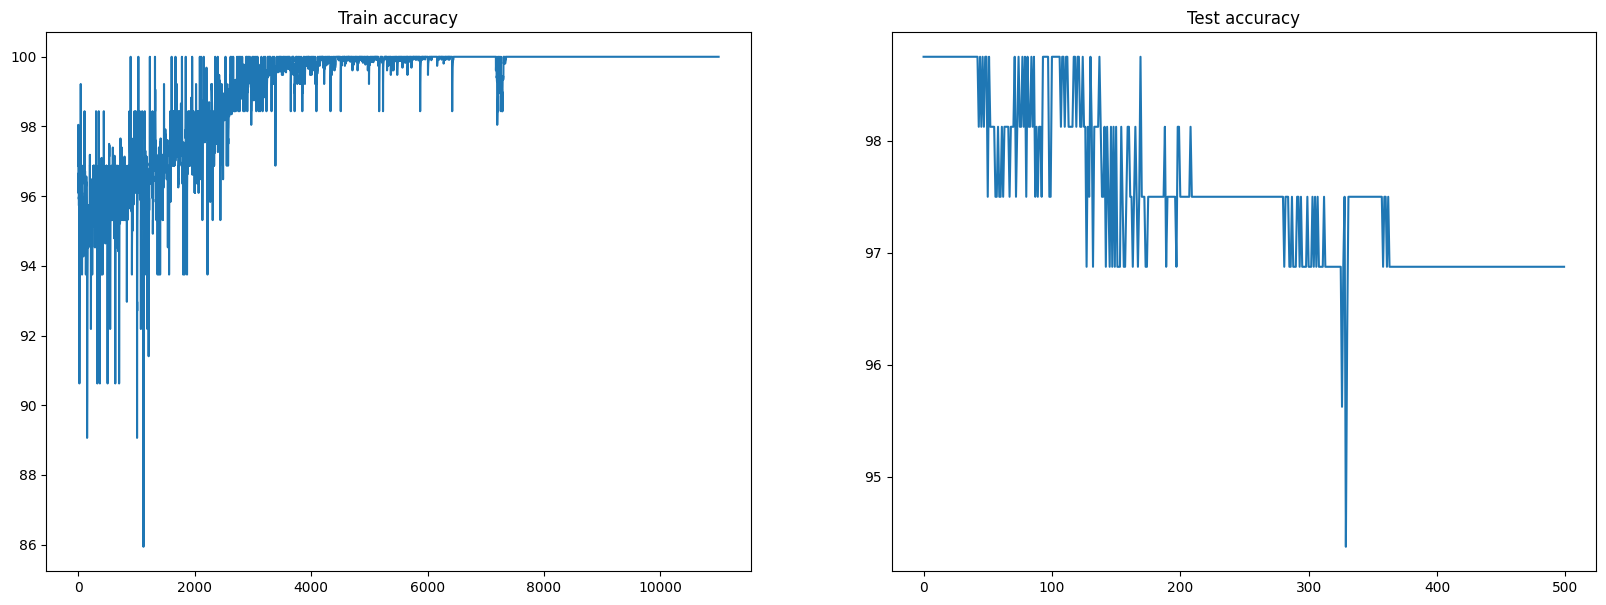

In [19]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(testAcc)
ax[1].set_title('Test accuracy')

# # common features
# for i in range(2):
#     ax[i].legend(activation_funs)
#     ax[i].set_xlabel('Epoch')
#     ax[i].set_ylabel('Accuracy (%)')
#     ax[i].set_ylim([40,100])
#     ax[i].grid()

plt.show()

In [20]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>6.5] = 1

# note: use the following lines to avoid the warning message
#tmp = (data['quality']>qualThreshold ).astype(int)
#data['boolQuality'] = tmp
  

/tmp/ipykernel_27205/1059227382.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>6.5] = 1


In [21]:
winenet = ANNwine('LeakyReLU')
trainAcc,testAcc,losses = trainTheModel()


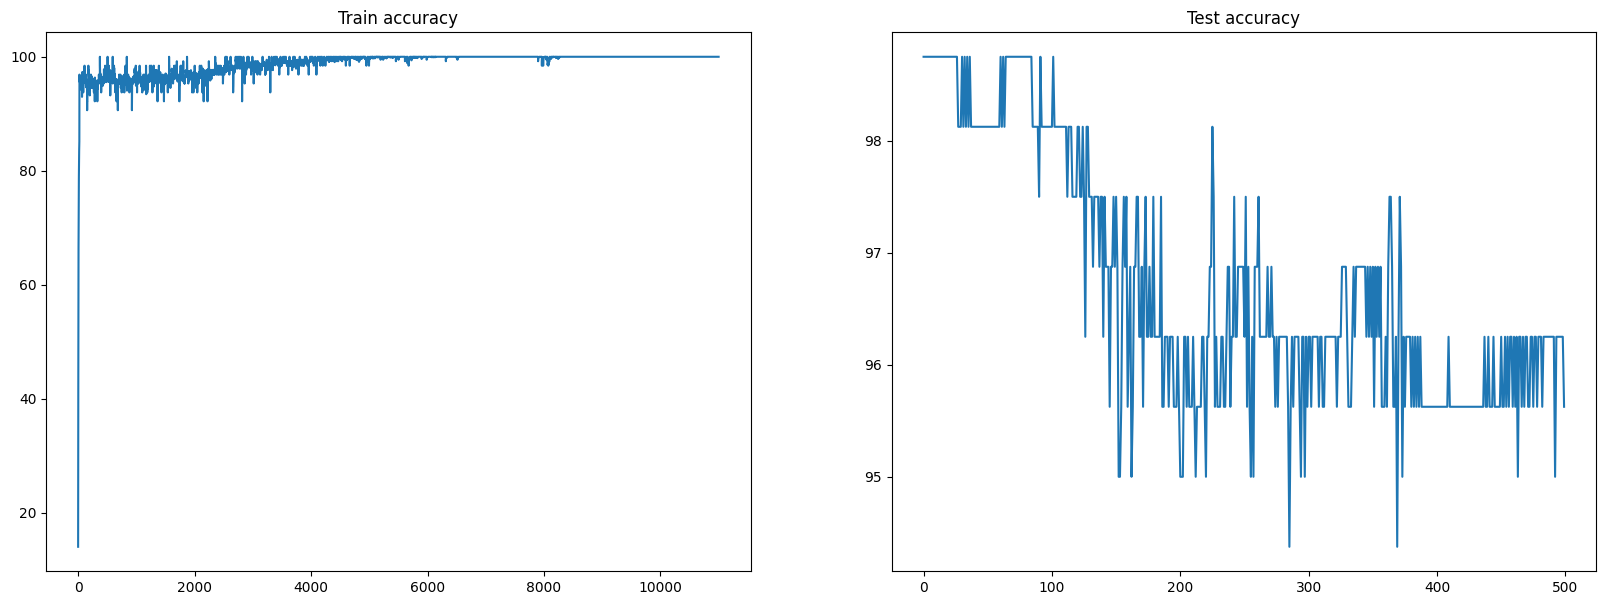

In [22]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(testAcc)
ax[1].set_title('Test accuracy')

# # common features
# for i in range(2):
#     ax[i].legend(activation_funs)
#     ax[i].set_xlabel('Epoch')
#     ax[i].set_ylabel('Accuracy (%)')
#     ax[i].set_ylim([40,100])
#     ax[i].grid()

plt.show()